# zonaprop analysis

# Schedule:
* General
* Data cleaning
* Exploratory analysis

# General

In [3]:
%matplotlib inline

import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot  as plt

from scipy import stats
from functools import partial

import cartopy.crs as ccrs
from cartopy.io import shapereader

from datetime import datetime

pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# Creamos el dataframe y le asignamos como id del dataframe, el id de cada row del csv.
df = pd.read_csv('train.csv', index_col='id')

In [5]:
#chequeo info general.
print("shape:", df.shape, "\n")
print("columns:", df.columns, "\n")
print(f"provincias: {df.provincia.unique()} \n")
print(f"tipodepropiedad: {df.tipodepropiedad.unique()}")

shape: (240000, 22) 

columns: Index(['titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object') 

provincias: ['Distrito Federal' 'Jalisco' 'Edo. de México' 'Oaxaca' 'Quintana Roo'
 'Colima' 'San luis Potosí' 'Nuevo León' 'Querétaro' 'Tamaulipas' 'Puebla'
 'Yucatán' 'Morelos' 'Guerrero' 'Tabasco' 'Guanajuato' 'Hidalgo'
 'Veracruz' 'Chihuahua' 'Aguascalientes' 'Sonora' 'Michoacán'
 'Baja California Norte' 'Baja California Sur' 'Coahuila' 'Durango'
 'Sinaloa' 'Chiapas' 'Nayarit' 'Tlaxcala' 'Campeche' 'Zacatecas' nan] 

tipodepropiedad: ['Apartamento' 'Casa en condominio' 'Casa' 'Terreno' 'Terreno comercial'
 'Local Comercial' 'Quinta Vacacional' 'Oficina comercial' 'Edificio'
 'Casa uso de suelo' 'Loc

# Data cleaning

In [6]:
# elimino features que no usaremos en el analisis del data set
# trabajando con un data set grande esto me ocuparia menos espacio en memoria y disco.
del df['titulo']
del df['descripcion']
del df['direccion']

In [47]:
#listo los datos faltantes
df_nulls = pd.DataFrame(df.isnull().sum().sort_values(), columns=['nulls'])
df_nulls = df_nulls[df_nulls.nulls > 0]
df_nulls['porcentaje'] = round(100*df_nulls['nulls'] / len(df), 2)
df_nulls['porcentaje_nonull'] = 100 - df_nulls.porcentaje
del df_nulls['nulls']

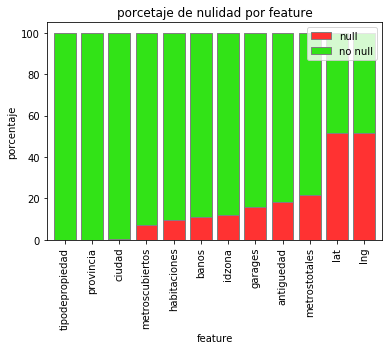

In [79]:
red = '#ff3232'; green = '#32E317'
df_nulls.plot.bar(stacked=True, color=[red, green], width= 0.8, edgecolor='grey', rot=90)
plt.legend(title='mark')
plt.title('porcetaje de nulidad por feature')
plt.xlabel('feature')
plt.ylabel('porcentaje')
plt.legend(['null', 'no null'])
#plt.yscale('linear') #default == linear
#plt.ylim(0,100) por default el upper bound es el valor maximo de la feature
#plt.grid(False)#default == false
plt.show()

In [ ]:
# lat y lng tiene un porcentaje alto de nulidad, 
# entonces mas adelante cuando haga analisis que dependen de lat y lng tener en cuenta de que es posible 
# que una cantidad grande de registros no podran ser analizados en base a lat y lng.
#
# Notar que no se analizo si la nulidad de lat y lng esta distribuida en partes iguales 
# o es para una ciudad o prov especifica

In [4]:
#normalizo tipodepropiedad, direccion, ciudad y provincia a lowercase
def convert_to_lower(df, feature):
    df[feature] = df[feature].str.lower()

convert_to_lower(df, 'tipodepropiedad')
convert_to_lower(df, 'ciudad')
convert_to_lower(df, 'provincia')

In [5]:
#valido que habitaciones, garages, banos sean valores enteros

def is_integer(number):
    frac, _ = math.modf(number)
    return frac == 0

def drop_nan_from_arr(arr):
    return [x for x in arr if ~np.isnan(x)]

def apply_all(arr, function):
    return all([function(x) for x in arr])

unique_habitaciones = df.habitaciones.unique()
unique_habitaciones = drop_nan_from_arr(unique_habitaciones)
print("unique_habitaciones:", apply_all(unique_habitaciones, is_integer))

unique_garages = df.garages.unique()
unique_garages = drop_nan_from_arr(unique_garages)
print("unique_garages:", apply_all(unique_garages, is_integer))

unique_banos = df.banos.unique()
unique_banos = drop_nan_from_arr(unique_banos)
print("unique_banos:", apply_all(unique_banos, is_integer))

unique_habitaciones: True
unique_garages: True
unique_banos: True


In [6]:
#'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas','centroscomercialescercanos'
# parecen ser booleanos por ser siempre 0 Y 1 y por la naturaleza del feature.
# Analizo si es acertada la suposicion, de serlo, los convierto en Boolean, van a ocupar menos espacio.

def is_boolean(x):
    return x == 0 or x == 1

def int_to_bool(x):
    return x != 0

unique_gimnasio = df.gimnasio.unique()
unique_gimnasio = drop_nan_from_arr(unique_gimnasio)
print("unique_gimnasio is_boolean:", apply_all(unique_gimnasio, is_boolean))
df.gimnasio = df.gimnasio == True

unique_usosmultiples = df.usosmultiples.unique()
unique_usosmultiples = drop_nan_from_arr(unique_usosmultiples)
print("unique_usosmultiples is_boolean:", apply_all(unique_usosmultiples, is_boolean))
df.usosmultiples = df.usosmultiples == True

unique_piscina = df.piscina.unique()
unique_piscina = drop_nan_from_arr(unique_piscina)
print("unique_piscina is_boolean:", apply_all(unique_piscina, is_boolean))
df.piscina = df.piscina == True

unique_escuelascercanas = df.escuelascercanas.unique()
unique_escuelascercanas = drop_nan_from_arr(unique_escuelascercanas)
print("unique_escuelascercanas is_boolean:", apply_all(unique_escuelascercanas, is_boolean))
df.escuelascercanas = df.escuelascercanas == True

unique_centroscomercialescercanos = df.centroscomercialescercanos.unique()
unique_centroscomercialescercanos = drop_nan_from_arr(unique_centroscomercialescercanos)
print("unique_centroscomercialescercanos is_boolean:", apply_all(unique_centroscomercialescercanos, is_boolean))
df.centroscomercialescercanos = df.centroscomercialescercanos == True

unique_gimnasio is_boolean: True
unique_usosmultiples is_boolean: True
unique_piscina is_boolean: True
unique_escuelascercanas is_boolean: True
unique_centroscomercialescercanos is_boolean: True


In [259]:
# VALIDO QUE TODAS LAS FECHAS DE LA FEATURE 'fecha' ESTEN ENTRE 2012 Y 2016

def date_between(date1, date2, date_to_compare):
    return date1 < date_to_compare and date_to_compare < date2

#aplicacion parcial de 'date_between(date1, date2, date_to_compare)'
partial_date_between = partial(date_between,'2012-00-00 00:00:00', '2017-00-00 00:00:00')
apply_all(df.fecha, partial_date_between)

# otra forma de hacer esta validacion seria usando el tipo de dato datetime, 
# probablemente mas performante tambien. Seria hacer algo como:
# df['fecha'] = df['fecha'].apply(func = (lambda x :(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))))
# luego la funcion date_between(...) hara algo como: 
# return 2012 < date_to_compare.year and date_to_compare.year < 2017

True

# Analisis Exploratorio

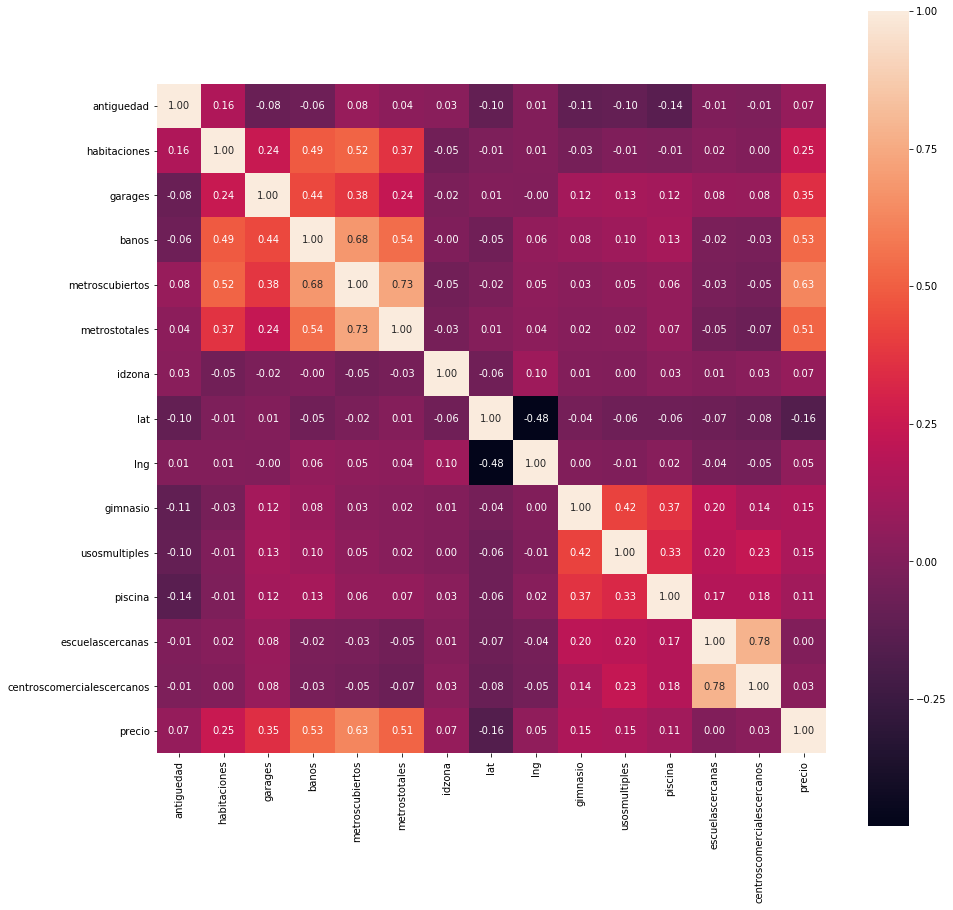

In [167]:
# Matriz de correlaciones como heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f');

In [ ]:
# Del grafico se desprende que las siguientes grupos de features estan correlacionadas (esto no implica causalidad)
# A) habitaciones, garages, banos, metroscubiertos, metrostotales entre si.
# B) Las features de (A) con respecto a precio
# C) centroscomercialescercanos con escuelascercanas
# D) gimnasio, usosmultiples, piscina

In [58]:
# Analizo (C)
# Hay una cierta probabilidad de que al exisitir centros comerciales cercanos tambien existiran
# escuelas cercanas y viceversa.

aux = df[['centroscomercialescercanos', 'escuelascercanas']]
aux = aux.groupby(['centroscomercialescercanos', 'escuelascercanas']).apply(lambda x: x.count())
aux = pd.DataFrame(aux.escuelascercanas, columns=['escuelascercanas'])

aux.columns = ['cantidad']
aux['porcentaje'] = round(100*aux['cantidad'] / len(df), 2)
aux

cantidad  porcentaje
centroscomercialescercanos escuelascercanas                      
False                      False               126153       52.56
                           True                 18679        7.78
True                       False                 7253        3.02
                           True                 87915       36.63

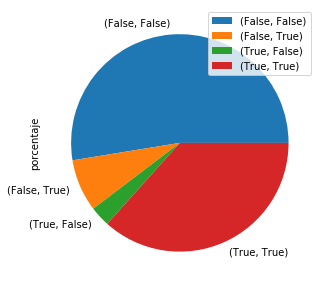

In [59]:
aux.plot.pie(y='porcentaje', figsize=(5, 5))

In [ ]:
#ENTIENDO QUE SI EL INDICE DE CORR ES DEL 0,78 ENTONCES SIGNIFICA QUE VOY A TENER GRAN GANTIDAD DE (TRUE,TRUE)
#ENTONCES VEMOS QUE APROX EL 89,19% DE LA INFO CUMPLE CON ESTO ASI QUE TIENE SENTIDO.

#POR OTRO LADO PODRIA GRAFICAR LOS (TRUE, TRUE) Y (FALSE, FALSE) DE UN UNICO COLOR Y EL RESTO DE OTRO COLOR
#REPRESENTARIA MEJOR LO QUE QUIERO INFORMAR.


In [61]:
# Analizo (D)
# Hay una probabilidad medianamente elevada de que la propiedad disponga 
# de gimnasio, usosmultiples y piscina a la vez. Al ser features booleanas un scatter plot no nos dara info relevante.

aux = df[['gimnasio', 'usosmultiples', 'piscina']]
aux = aux.groupby(['gimnasio', 'usosmultiples', 'piscina']).apply(lambda x: x.count())
aux = pd.DataFrame(aux.gimnasio, columns=['gimnasio'])

aux.columns = ['cantidad']
aux['porcentaje'] = round(100*aux['cantidad'] / len(df), 2)
aux

cantidad  porcentaje
gimnasio usosmultiples piscina                      
False    False         False      206412       86.00
                       True        11709        4.88
         True          False        4988        2.08
                       True         1897        0.79
True     False         False        5618        2.34
                       True         3039        1.27
         True          False        2010        0.84
                       True         4327        1.80

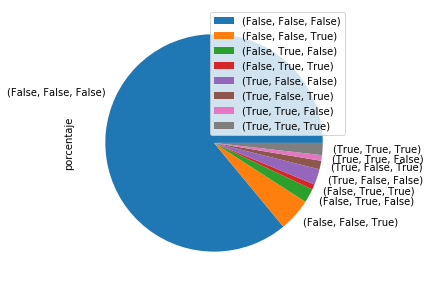

In [62]:
aux.plot.pie(y='porcentaje', figsize=(5, 5))

In [ ]:
#ANALIZAR MEJOR ESTE GRAFICO DE TORTA, HACE RUIDO TANTO (FALSE,FALSE,FALSE)

In [33]:
df_corr = df.filter(['habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales'], axis=1)

In [35]:
#funciones que me permiten graficar el data set con el fin de detectar outliers visualmente

def get_column(A, j): 
    return A.iloc[:,j]

def scatter_matrix(df_corr, figsize):
    
    df_corr = df_corr.copy()
    df_corr = df_corr.dropna()
    df_corr = df_corr.sample(1000, random_state=1)

    _, num_columns = df_corr.shape
    fig, ax = plt.subplots(num_columns, num_columns, figsize = figsize) 

    for i in range(num_columns):
        for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
            if i != j: ax[i][j].scatter(get_column(df_corr, j), get_column(df_corr, i), alpha=0.15)

            # unless i == j, in which case show the series name
            else: ax[i][j].annotate("series " + str(i), (0.5, 0.5), 
                                    xycoords='axes fraction', 
                                    ha="center", va="center")

            # then hide axis labels except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False) 
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them 
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim()) 
    ax[0][0].set_ylim(ax[0][1].get_ylim())

    plt.show()
    
def scatter_list(df_corr, fixed_column, figsize):
    _, num_columns = df_corr.shape
    fig, ax = plt.subplots(1, num_columns, figsize = figsize) 

    for i in range(num_columns):
        
        i_column = get_column(df_corr, i)
        aux = pd.DataFrame()
        aux['A'] = i_column
        aux['B'] = fixed_column
        aux.dropna()
        aux = aux.sample(1000, random_state=1)

        ax[i].scatter(aux['A'], aux['B'], alpha=0.15)
        ax[i].xaxis.set_visible(True) 
        ax[i].yaxis.set_visible(True)

    plt.show()
    
def boxplot_list(df):
    
    df = df.copy().dropna()

    _, num_columns = df.shape
    fig, ax = plt.subplots(1, num_columns, figsize = (4 * num_columns, 4)) 
    red_square = dict(markerfacecolor='r', marker='s')

    
    for i in range(num_columns):        
        i_column = get_column(df, i)
        i_column = i_column.sample(1000, random_state=1)

        ax[i].boxplot(x=i_column, vert=False, flierprops=red_square)
        ax[i].xaxis.set_visible(True) 
        ax[i].yaxis.set_visible(True)

    plt.show()

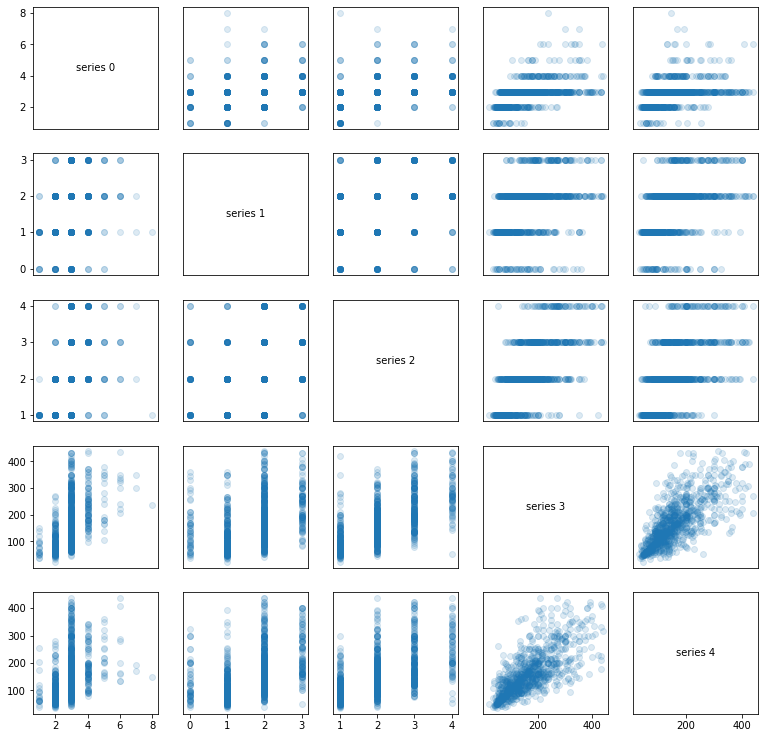

In [36]:
# Analizo (A) -> habitaciones, garages, banos, metroscubiertos, metrostotales entre si.
scatter_matrix(df_corr, figsize=(13,13))

In [11]:
# Analizo(A)

################

# 'habitaciones'

# con respecto a 'garages': 
# propiedades de 2 a 5 habitaciones tienen todo el espectro de garages.
# no hay propiedades de 5 a 8 habitaciones que no tengan garage.

# con respecto a 'banos'
# propiedades de 2 a 5 habitaciones tienen todo el espectro de banos.

# con respecto a 'metrostotales'
# propiedades de 4 a 5 piezas tienen gran variedad con respecto a metros cubiertos
# se visualiza una tendencia a mayor numero de habitaciones mayor metros cubiertos

# con respecto a 'metrostotales'
# propiedades de 4 a 5 piezas tienen gran variedad con respecto a metros totales
# se visualiza una tendencia a mayor numero de habitaciones mayor metros totales

################

# 'garages'

# con respecto a 'banos'
# se puede encontrar propiedades con 0 a 3 garages que tambien tienen de 1 a 4 banos

# con respecto a 'metrostotales' 
# parece que hay una leve tendencia donde a propiedad con mayor metros totales, mayor cantidad de garages.

# con respecto a 'metroscubiertos' 
# parece que hay una leve tendencia donde a propiedad con mayor metros cubiertos, mayor cantidad de garages.

################

# 'banos'
# con respecto a 'metrostotales' 
# parece que hay una leve tendencia donde a propiedad con mayor metros totales, mayor cantidad de banos.

# con respecto a 'metroscubiertos'
# parece que hay una leve tendencia donde a propiedad con mayor metros cubiertos, mayor cantidad de banos.

################

# 'metroscubiertos' con respecto a 'metrostotales'
# hay una tendencia fuerte donde a propiedad con mayor metros totales, mayor cantidad de metros cubiertos.


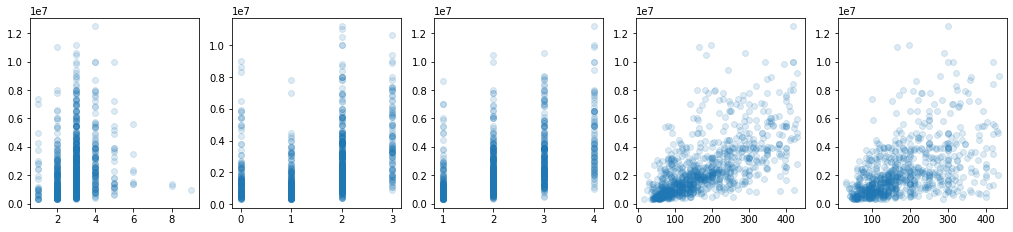

In [37]:
# Analizo (B) -> Las vars de (A) con precio
_, num_columns = df_corr.shape
fixed_column = df.filter(['precio'], axis=1)
scatter_list(df_corr, fixed_column, figsize=(3.5 * num_columns, 3.5))

In [ ]:
# precio

# con respecto a 'habitaciones':
# la mayor cantidad de publicaciones son de 2 a 4 habitaciones.
# hay pocas publicaciones de > 6 habitaciones y no son precios mas elevados que las publ. con habitaciones de 2 a 4.

# con respecto a 'garages': 
# pareciera poder encontrarse publ. con garages de 0 a 2 con precio similar.
# se encuentras solo algunos precios elevados para publ. con garages de 2 a 3

# con respecto a 'banos': 
# pareciera poder encontrarse publ. con banos de 1 a 4 con precio similar.
# pareciera que no hay muchos precios elevados con 1 baño.

# con respecto a 'metroscubiertos' y 'metrostotales': 
# se pueda observar la tendencia de que a mayor precio tenemos mas 'metroscubiertos' y 'metrostotales'

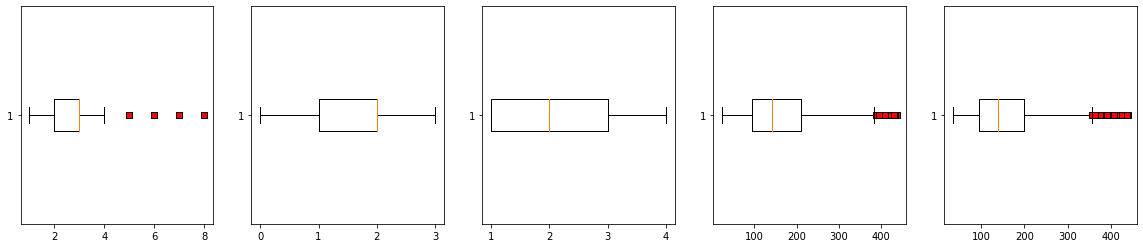

In [38]:
# BOXPLOTS

# hago graficos boxplot de con el objetivo de ver outliers y entender un poco mejor
# la distribucion de las features numericas: 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales'.
boxplot_list(df_corr)

In [121]:
# habitaciones
# el 50% de las publicaciones tienen habitaciones de 2 y 3
# la mayoria de las publicaciones tienen habitaciones de 1 a 4
# presenta outliers. Son valores validos, son pocas las publicaciones con habitaciones > 4

# garages
# el 50% de las publicaciones tienen garages de 1 y 2
# la mayoria de las publicaciones tienen garages de 0 a 3
# no presenta outliers

# banos
# el 50% de las publicaciones tienen banos de 1 y 3
# la mayoria de las publicaciones tienen banos de 1 a 4
# no presenta outliers.

# metroscubiertos
# el 50% de las publicaciones tienen metroscubiertos entre 100 y 200 aproximadamente
# la mayoria de las publicaciones tienen metroscubiertos mayor a 0 aproximadamente y menor a 400
# presenta outliers. Son valores validos, son pocas las publicaciones con metroscubiertos > 400 aprox

# metrostotales
# el 50% de las publicaciones tienen metrostotales entre 100 y 200 aproximadamente
# la mayoria de las publicaciones tienen metrostotales mayor a 0 aproximadamente y menor a 350
# presenta outliers. Son valores validos, son pocas las publicaciones con metrostotales > 350 aprox

In [64]:
# COMENTARIOS GENERALES SOBRE ANALISIS DE BOXPLOTS

# Cuando la variable en analisis tiene pocos valores para tomar, se puede dar que el percentil 1 solo tenga 1 valor
# entonces no se podra ver el bigote que indica cuantos valores abarca este percentil,
# como por ejemplo, se puede observar en 'baños'.

# Tambien puede suceder que la mediana (percentil 2) este en el mismo valor que el percentil 1 o 3, como se puede
# observar en 'garages'.

# IQR = Q3 - Q1
# comienzo del bigote: Q1 - 1.5*IQR
# final del bigote: Q3 + 1.5*IQR

# https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

banos_df = pd.DataFrame(df.groupby('habitaciones').apply(lambda x: x.dropna().habitaciones.count()))
banos_df['porcentaje'] = round(100*banos_df / banos_df.sum(), 2)
banos_df

,0,porcentaje
habitaciones,,
1.00,993,1.80
2.00,15054,27.26
3.00,31489,57.02
4.00,6104,11.05
5.00,1032,1.87
6.00,340,0.62
7.00,114,0.21
8.00,57,0.10
9.00,23,0.04


In [56]:
# encuentro outliers con una desviacion estandar normal > 3
threshold = 3
z = np.abs(stats.zscore(df_corr.dropna()))
outliers = np.where(z > threshold)
#outliers[0] corresponde al nro de row
#outliers[1] corresponde al nro de col
outliers

,0,1,2,3,4,5,6,7,8,9,...,2553,2554,2555,2556,2557,2558,2559,2560,2561,2562
0,56,146,154,170,193,315,362,365,517,545,...,139019,139087,139091,139091,139128,139159,139169,139182,139329,139365
1,4,4,4,0,0,4,3,4,0,0,...,3,4,3,4,4,3,0,4,3,0


### Punto 1

In [128]:
#ver que provincia historicamente acumula los precios mas caras y cual las mas baratas
df1 = df.copy()

In [71]:
#agrupo por provincia, hago sumatoria de los precios y ordeno de mayor a menor
df1 = df.groupby(['provincia']).precio.sum().sort_values(ascending=False)

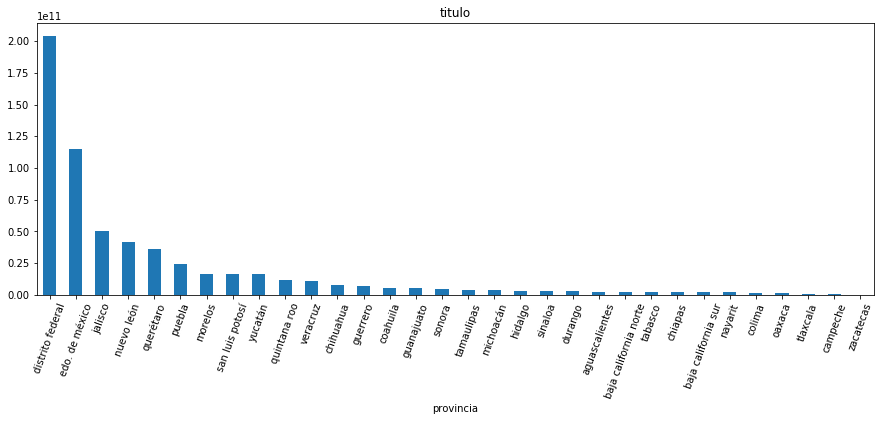

In [72]:
df1.plot(kind='bar', figsize=(15, 5), rot=70, title="titulo");

In [ ]:
# Pensando en terminos monetarios solamente (y no cantidad de publicaciones) podemos observar en el grafico de arriba
# cuales son las provincias que mas dinero pueden llegar a dejar en caso de concretarse las ventas.
#

In [25]:
df1 = df.copy()

In [26]:
# agrupo por ciudad, hago sumatoria de los precios y ordeno de mayor a menor
# muestro las 1eras 15 para tener una referencia.
df1 = df1.groupby(['ciudad']).precio.sum().nlargest(15)

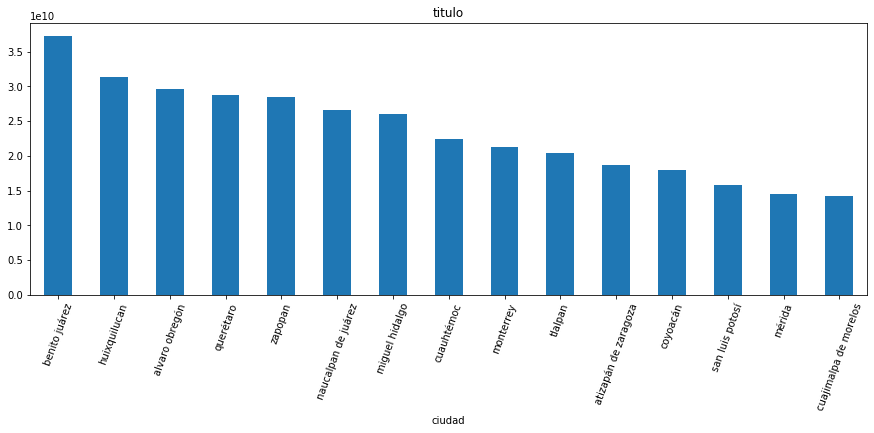

In [27]:
df1.plot(kind='bar', figsize=(15, 5), rot=70, title="titulo");

In [ ]:
# Pensando en terminos monetarios solamente (y no cantidad de publicaciones) podemos observar en el grafico de arriba
# cuales son las ciudades que mas dinero pueden llegar a dejar en caso de concretarse las ventas.
#

In [46]:
#agrupo por provincia y ciudad, luego obtengo los 2 precios mas alto por cada agrupacion.
df1 = df.copy()
#df1 = pd.DataFrame(df1.groupby(['provincia', 'ciudad']).precio.sum())
df1 = pd.DataFrame(df1.groupby(['provincia', 'ciudad']).apply(lambda x: x.precio.nlargest(2)))
df1

#DEVUELVE 1500 ROWS APROX, DONDE ENTONCES ME QUEDAN 750 SUBGRUPOS APROX.
#NO ESTOY SEGURO COMO HACER UN BUEN GRAFICO CON ESTO.

precio
provincia             ciudad                    id                
aguascalientes        aguascalientes            154112 12312122.00
                                                64714  10900000.00
                      asientos                  184875  3120000.00
                                                273179  2800000.00
                      calvillo                  293349  3360000.00
                                                25790    950000.00
                      cosío                     262385  1000000.00
                                                28646    980000.00
                      el llano                  126348  2200000.00
                                                153298  1200000.00
                      jesús maría               215438  6200000.00
                                                298304  5350000.00
                      pabellón de arteaga       15948   1400000.00
                                                218993  1300000.00
                      rincón de romos           164007  6000000.00
                                                161482  2200000.00
                      san francisco de los romo 60823    600000.00
                                                237549   600000.00
                      tepezalá                  145339  1200000.00
                                                137715  1000000.00
baja california norte ensenada                  245405  6500000.00
                                                275322  5500000.00
                      mexicali                  153392  7200000.00
                                                211081  4990000.00
                      playas de rosarito        264490  4053000.00
                                                156096  3903000.00
                      tecate                    195090  2500000.00
                                                249078  1000000.00
                      tijuana                   178471  8055000.00
                                                66096   8055000.00
...                                                            ...
yucatán               tinum                     69335   1980000.00
                      tizimín                   100507  5950000.00
                                                82989   4000000.00
                      tzucacab                  282711  7800000.00
                      uayma                     189647   600000.00
                      ucú                       204788  8500000.00
                      umán                      87017   7500000.00
                                                250041  4000000.00
                      valladolid                15551   8000000.00
                                                277416  4200000.00
                      yaxcabá                   153241  2500000.00
                      yaxkukul                  178124  2250000.00
                      yobaín                    153425  1300000.00
                                                65833   1100000.00
zacatecas             calera                    132448  1600000.00
                                                137906   372000.00
                      fresnillo                 267424  1100000.00
                      guadalupe                 260367  3800000.00
                                                267914  3497793.00
                      jerez                     13673   1598000.00
                                                190742  1198000.00
                      morelos                   262680  2450000.00
                                                58226    400000.00
                      río grande                224128  1150000.00
                      sombrerete                57022   2700000.00
                      tepechitlán               263086  1500000.00
                      villa de cos              171176  1050000.00
                      villanueva        

In [ ]:
#
# HACER !!!!
# HACER ANALISIS POR TIPOS DE PROPIEDAD (EJ: CASA, DPTO, DUPLEX, ETC) DEL ACUMULADO DE $ QUE DEJA CADA UNA.
#

### Punto 2

In [296]:
#ver cual provincia tiene mas desvio estandar en sus precios, (idem para ciudades) 
df2 = df.copy()

In [292]:
#ANALISIS NUMERICO
df2 = df.copy()
df2 = df2.groupby(['provincia']).precio.agg(['std','mean']).sort_values(by='mean')
df2['std > 25%'] = df2['std'] > (df2['mean'] * 0.25)
df2

,std,mean,std > 25%
provincia,,,
Baja California Norte,678467.98,767441.75,True
Tlaxcala,1087415.56,1080993.34,True
Durango,919869.33,1210388.98,True
Baja California Sur,1003929.42,1216452.82,True
Hidalgo,1159939.77,1305550.54,True
Nayarit,1402039.15,1426790.82,True
Zacatecas,1791470.94,1453747.80,True
Aguascalientes,1170392.69,1477188.77,True
Michoacán,1315847.58,1478503.67,True


In [29]:
#ANALISIS NUMERICO
df2 = df.copy()
df2 = df2.groupby(['provincia','ciudad']).precio.agg(['std','mean'])#como parametrizo cuando paso asi las funciones ??
df2['std > 25%'] = df2['std'] > (df2['mean'] * 0.25)
df2['std'].head()
#
# > std NaN ??????
# > para los casos que da NaN se da que tiene 1 solo elemento o tiene > 1 pero el valor es el mismo entonces no tiene desviacion
#

provincia       ciudad        
Aguascalientes  Aguascalientes   1213727.34
                Asientos         1102986.01
                Calvillo         1485946.50
                Cosío             179257.73
                El Llano          808290.38
Name: std, dtype: float64

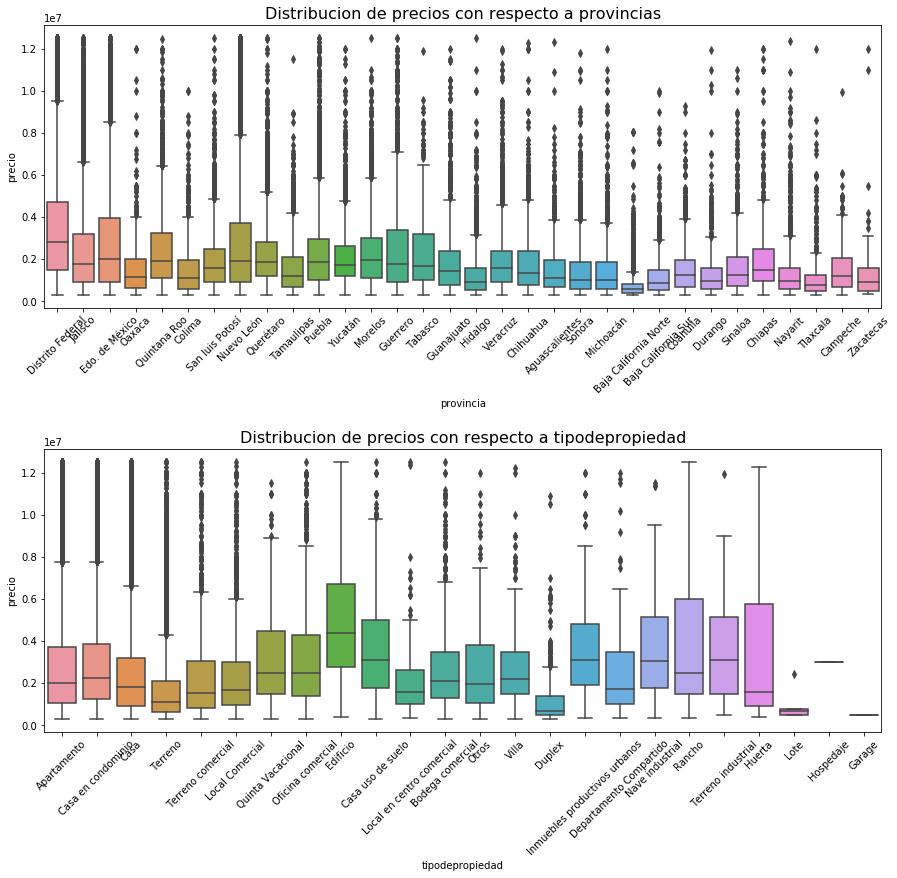

In [297]:
#ANALISIS GRAFICO
fig, ax = plt.subplots(figsize = [15,13], nrows = 2)
plt.subplots_adjust(hspace = 0.5)

ax[0].set_title('Distribucion de precios con respecto a provincias',fontsize = 16)
sns.boxplot(x= df2['provincia'], y=df2['precio'], ax = ax[0])
ax[0].tick_params(axis='x', rotation=45)

ax[1].set_title('Distribucion de precios con respecto a tipodepropiedad',fontsize = 16)
sns.boxplot(x= df2['tipodepropiedad'], y=df2['precio'], ax = ax[1])
ax[1].tick_params(axis='x', rotation=45)

plt.show()

### Punto 3

In [131]:
# 3)
# analizar publ y sus precios agrupadas geograficamente dentro de esa ciudad/provincia

In [74]:
df3 = df.copy()
df3 = df3[['lat','lng','precio']]
df3.dropna(inplace= True)

In [75]:
#
# HACER!!!!
# AVERIGUAR COMO PODRIA REMOVER PUBL QUE NO SON DE PROPIEDADES EN MEXICO 
#

In [76]:
# parametros segun https://www.naturalearthdata.com
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

#descargo el shape file de https://www.naturalearthdata.com
shpfilename = shapereader.natural_earth(resolution, category, name)
reader = shapereader.Reader(shpfilename)
countries = reader.records()

In [77]:
poly = None

# busco y obtengo a mano el objeto de tipo Record de Mexico y obtengo su geometry (el contorno de Mexico)
for country in countries:
    if country.attributes['ADMIN'] == 'Mexico':
        poly = country.geometry

In [78]:
poly is None

False

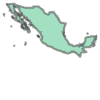

In [79]:
poly

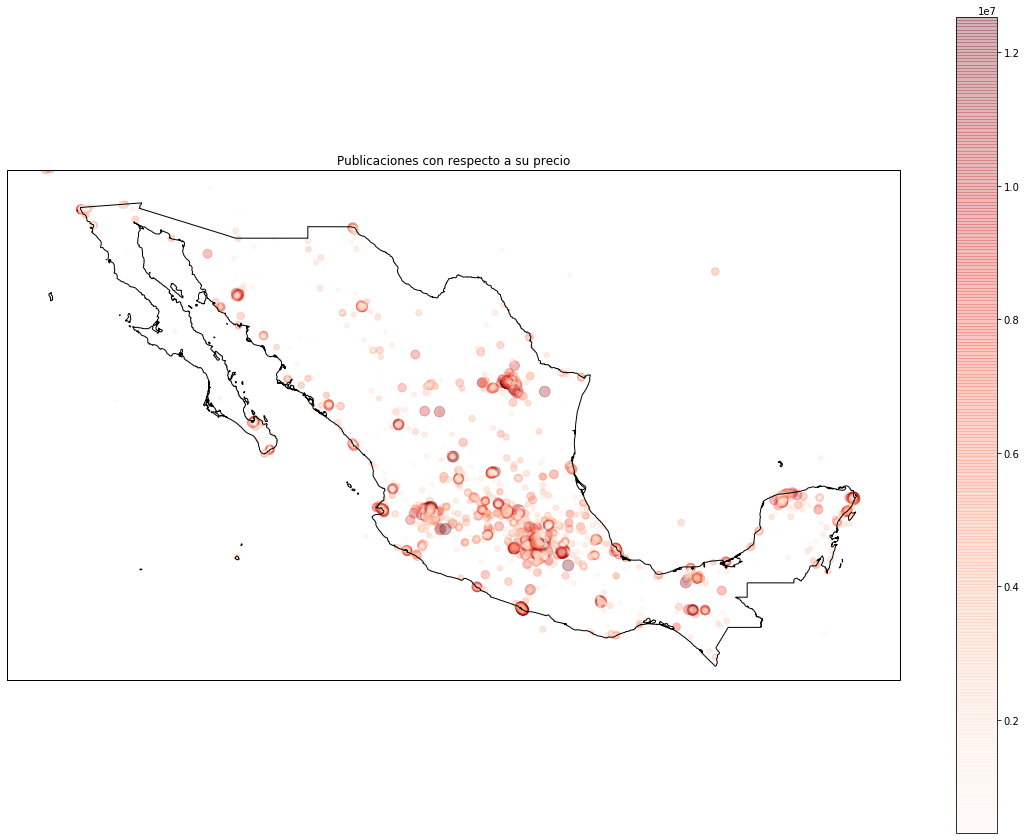

In [81]:
plt.figure(figsize = [20,15])

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0')

df3.plot(kind="scatter", x="lng", y="lat", s=df3['precio']/10**5,
                 c = df3['precio'], cmap="Reds", colorbar=True, ax=ax, alpha=0.3)
plt.title('Publicaciones con respecto a su precio')

#Set the map on mexico's location
ax.set_extent([-120, -85, 14, 34], crs=ccrs.PlateCarree())

### Punto 3*

In [ ]:
#HACER OTRO MAPA PERO PARA DISTRITO FEDERAL QUE ES LA LOCALIDAD QUE MAS CONCENTRA.

In [86]:
resolution = '10m'
category = 'cultural'
name = 'admin_1_states_provinces'

shpfilename = shapereader.natural_earth(resolution, category, name)
reader = shapereader.Reader(shpfilename)
countries = reader.records()

In [87]:
poly = None
for country in countries:
    if country.attributes['admin'] == 'Mexico' and country.attributes['name'] == 'distrito federal':
        poly = country.geometry

In [88]:
poly is None

True

In [234]:
poly.bounds
# (minx, miny, maxx, maxy)
# (-99.33473222501215, 19.057803453166798, -98.93914913632358, 19.57105377900865)

# reordeno (minx, miny, maxx, maxy) A (minx, maxx, miny, maxy) 
# esto lo hago para que lo use la funcion "set_extent" que recibe de la forma (left, right, bottom, top)
# >> (-99.33473222501215,  -98.93914913632358, 19.057803453166798, , 19.57105377900865)

(-99.33473222501215, 19.057803453166798, -98.93914913632358, 19.57105377900865)

In [82]:
def graficar_mapa(df3):
    
    plt.figure(figsize = [15,15])

    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0')

    df3.plot(kind="scatter", x="lng", y="lat", s=df3['precio']/10**6,
                 c = df3['precio'], cmap="Reds", colorbar=True, ax=ax, alpha=0.5)
    plt.title('Location with respect to the sale price')

    ax.set_extent([-99.9, -98.3, 18.8, 19.8], crs=ccrs.PlateCarree())

In [271]:
df3 = df.copy()
df3 = df3.loc[df3.provincia == 'distrito federal']

df3 = df3[['lat','lng','precio']]
df3.dropna(inplace= True)

In [ ]:
#
# HACER!!!!
# AVERIGUAR COMO PODRIA REMOVER PUBL QUE NO SON DE PROPIEDADES EN DF 
#

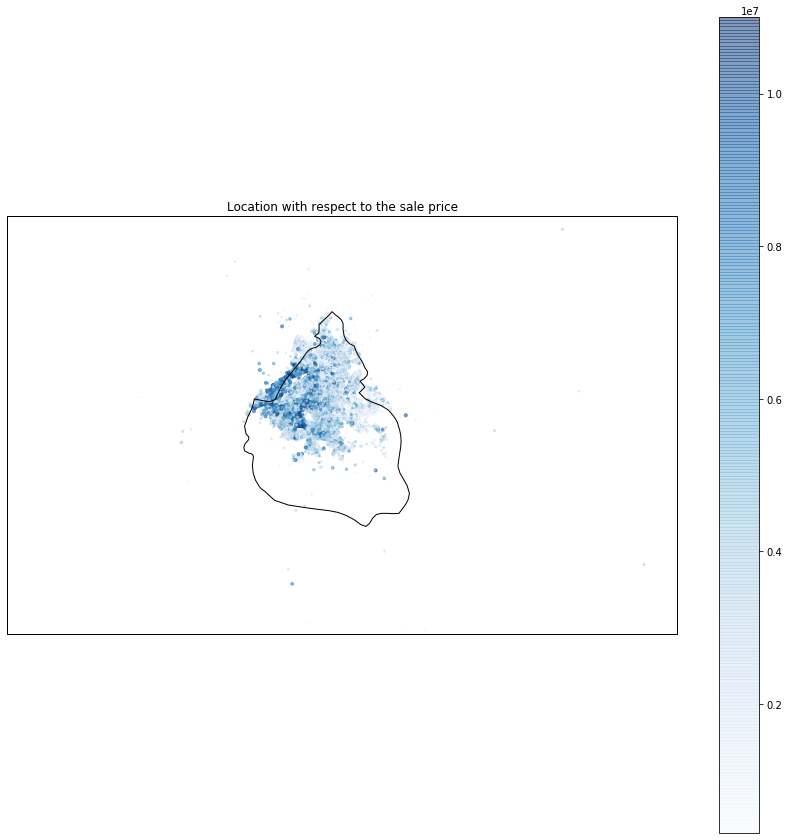

In [274]:
graficar_mapa(df3)

In [ ]:
#
# Se puede ver que la mayoria de las publicaciones estan en el centro y norte de DF.
# Se puede observar en el acumulado historico que el noroeste de DF tiene publicaciones con precios mas elevados
#

In [ ]:
#
#
#ANALIZAR LOS DISTINTOS AÑOS PARA AVERIGUAR SI LAS ZONAS CARAS A TRAVES DE LOS AÑOS FUERON CAMBIANDO
#
#

In [280]:
df3 = df.copy()
df3 = df3.loc[df3.provincia == 'distrito federal']

df3 = df3[['lat','lng','precio','fecha']]
df3.dropna(inplace= True)

df3['fecha'] = df3['fecha'].apply(func = (lambda x :(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))))
df3['year'] = df3['fecha'].apply(func = (lambda t : int(t.year)))

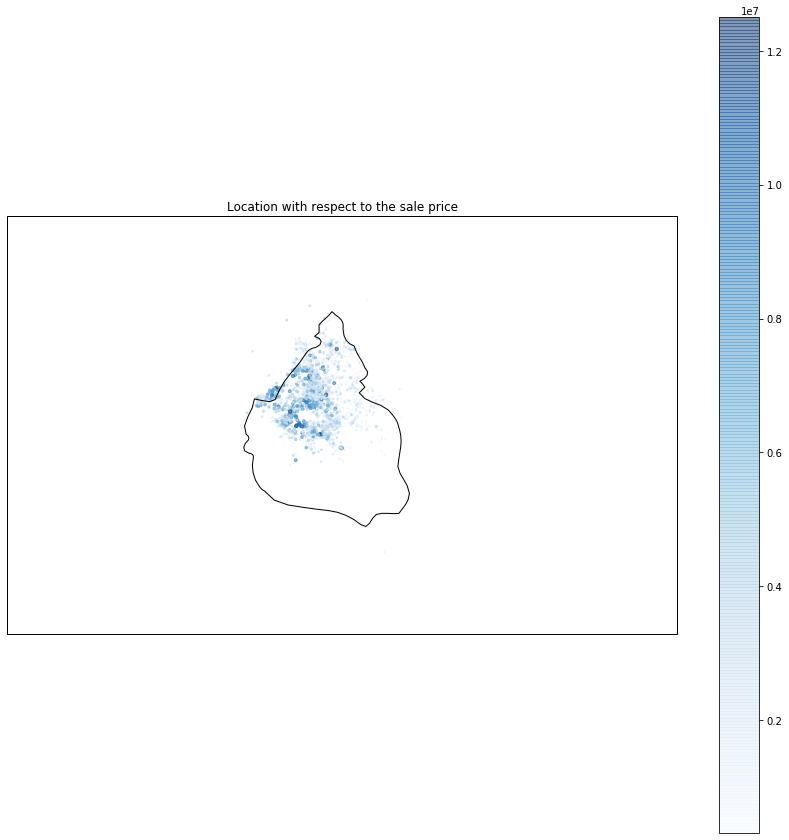

In [281]:
graficar_mapa(df3.loc[df3.year == 2012])

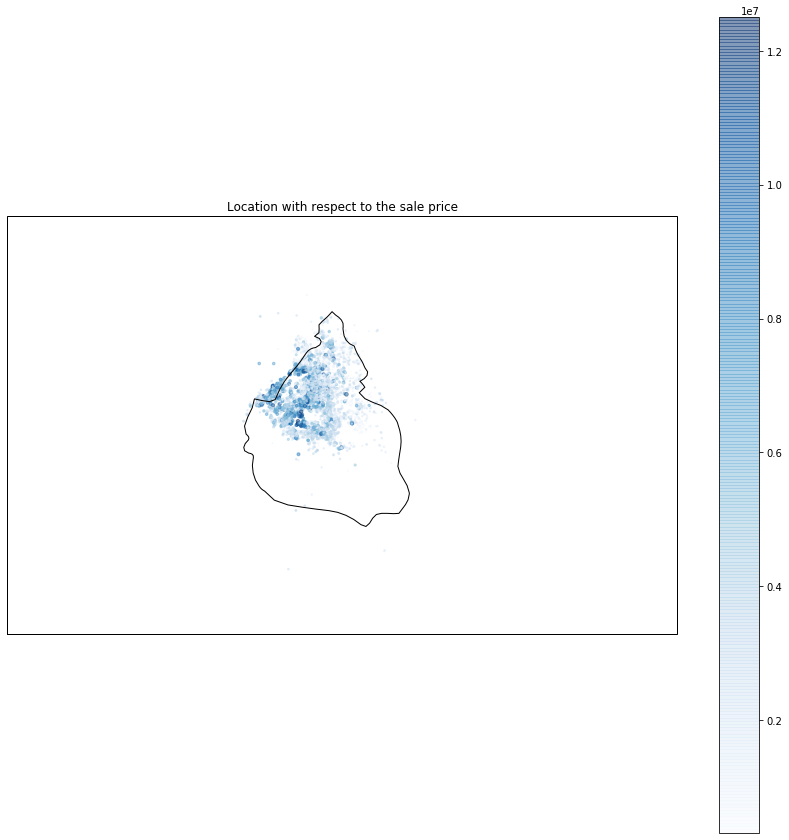

In [287]:
graficar_mapa(df3.loc[df3.year == 2013])

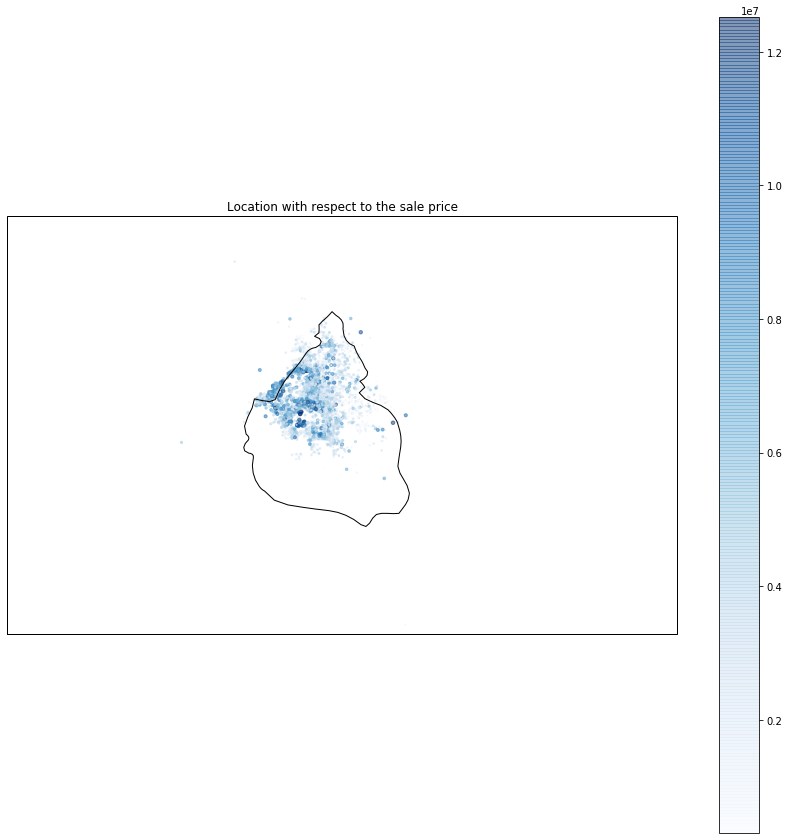

In [285]:
graficar_mapa(df3.loc[df3.year == 2014])

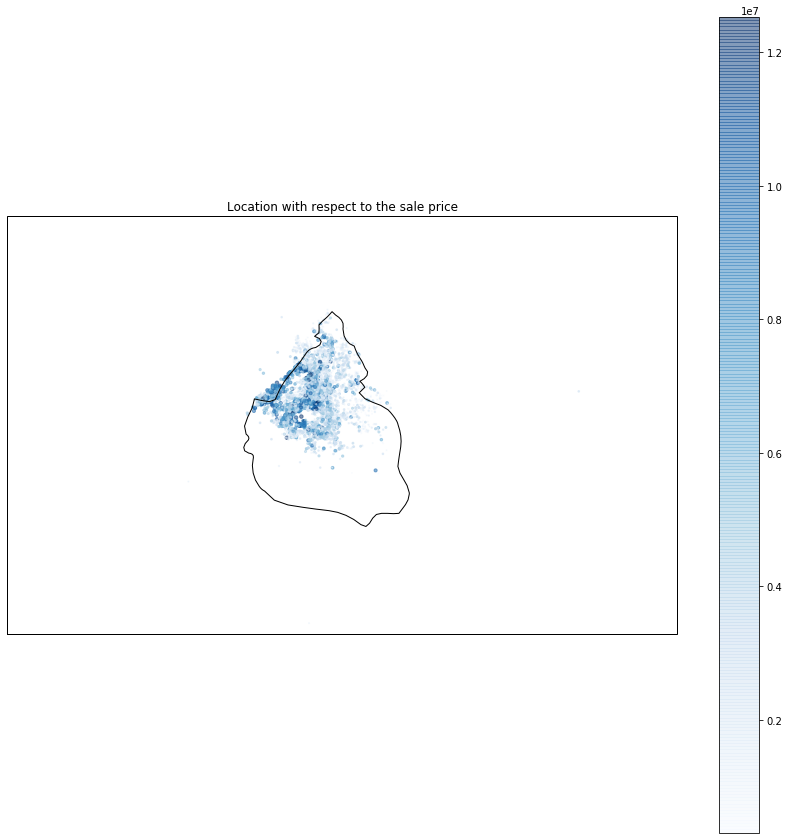

In [286]:
graficar_mapa(df3.loc[df3.year == 2015])

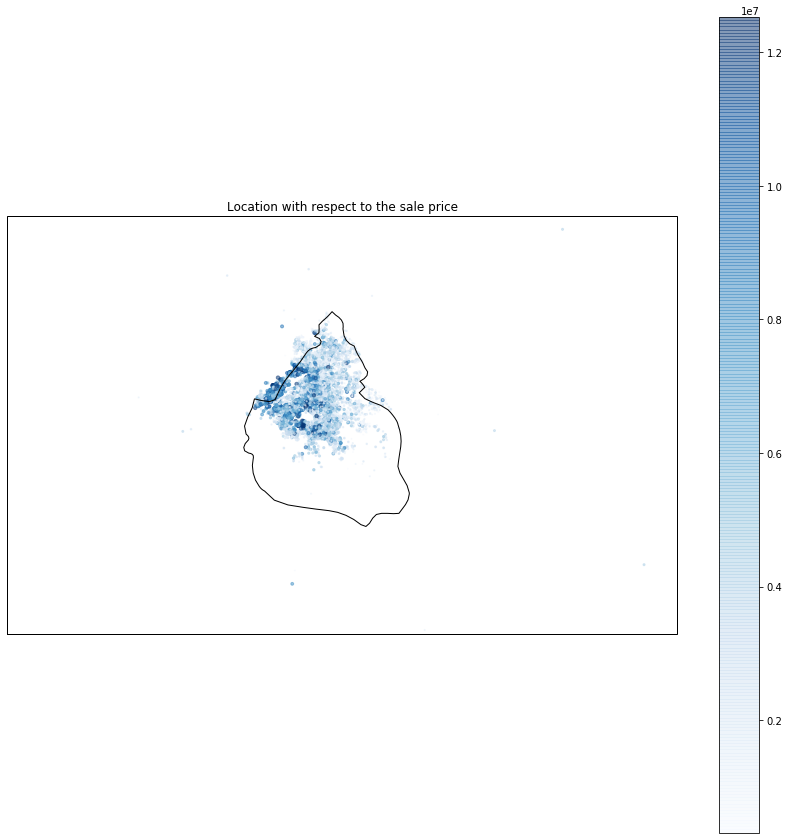

In [283]:
graficar_mapa(df3.loc[df3.year == 2016])

In [ ]:
#
# Podemos observar que la mayoria de las publicaciones a traves de los años siempre fueron de propiedades
# en el centro y noreste de DF, y ademas, se observa como el noroeste es levemente mas caro que el resto de DF.
#

### Punto 4

In [ ]:
# 4) ver si coincide que las provincias con casas mas caras son las que mas cantidad 
# de casas en venta tienen o al reves o que pasa

In [74]:
df6 = df.copy()

In [113]:
provincias_caras = pd.DataFrame(df6.groupby(["provincia"]).precio.sum()).nlargest(10,'precio')

In [55]:
provincias_pobladas = pd.DataFrame(df6.groupby(["provincia"]).count()).nlargest(10,'precio')

In [57]:
pd.merge(provincias_caras, provincias_pobladas, how='inner', on='provincia').index

Index(['Distrito Federal', 'Edo. de México', 'Jalisco', 'Nuevo León',
       'Querétaro', 'Puebla', 'Morelos', 'San luis Potosí', 'Yucatán'],
      dtype='object', name='provincia')

In [ ]:
#
# HACER !!!
# PODRIA GRAFICAR EL CALCULO DE ARRIBA CON UN DIAGRAMA DE VENN
#

In [ ]:
# 6') ver si coincide que la ciudad con casas mas caras de cada provincia, es tambien la ciudad de esa provincia
# que mas cantidad de casas en venta tienen, o al reves o que pasa.

In [107]:
df6aux = pd.DataFrame(df6.groupby(['provincia','ciudad']).precio.sum())
df6aux.groupby(['provincia']).apply(lambda _df: _df.nlargest(3,'precio'))

precio
provincia             provincia             ciudad                                    
Aguascalientes        Aguascalientes        Aguascalientes               2243174932.00
                                            Jesús María                   303752411.00
                                            Asientos                        9774348.00
Baja California Norte Baja California Norte Tijuana                      2083138547.00
                                            Mexicali                      252931142.00
                                            Ensenada                       91791746.00
Baja California Sur   Baja California Sur   La Paz                       1265172784.00
                                            Los Cabos                     791048253.00
                                            Comondú                         4618760.00
Campeche              Campeche              Carmen                        220702672.00
                                            Campeche                      173363225.00
                                            Champotón                      10823000.00
Chiapas               Chiapas               Tuxtla Gutiérrez             1655345025.00
                                            San Cristóbal de las Casas    285128374.00
                                            Tapachula                      56134170.00
Chihuahua             Chihuahua             Chihuahua                    7128224103.00
                                            Juárez                        580455959.00
                                            Cuauhtémoc                     85123207.00
Coahuila              Coahuila              Saltillo                     3025135396.00
                                            Torreón                      2056099458.00
                                            Ramos Arizpe                  275646884.00
Colima                Colima                Manzanillo                    604614577.00
                                            Colima                        561155871.00
                                            Villa de Alvarez              235996568.00
Distrito Federal      Distrito Federal      Benito Juárez               37278274667.00
                                            Alvaro Obregón              29646339282.00
                                            Miguel Hidalgo              26057366112.00
Durango               Durango               Durango                      2502042068.00
                                            Gómez Palacio                 138911229.00
                                            Lerdo                          72358280.00
...                                                                                ...
Quintana Roo          Quintana Roo          Cancún                       9335785213.00
                                            Playa del Carmen             1152045298.00
                                            Solidaridad                   585228299.00
San luis Potosí       San luis Potosí       San Luis Potosí             15743768359.00
                                            Soledad de Graciano Sánchez   282400413.00
                                            Cerro de San Pedro             13170000.00
Sinaloa               Sinaloa               Culiacán                     1454383052.00
                                            Mazatlán                     1247247195.00
                                            Ahome                         174870202.00
Sonora                Sonora                Hermosillo                   3987496282.00
                                            Cajeme                        203495660.00
                                            Guaymas                        93492671.00
Tabasco               Tabasco               Villahermosa                 1025293607.00
                                            Centro                        8868

In [108]:
df6aux_prima = pd.DataFrame(df6.groupby(['provincia','ciudad']).precio.count())
df6aux_prima.groupby(['provincia']).apply(lambda _df: _df.nlargest(3,'precio'))

precio
provincia             provincia             ciudad                             
Aguascalientes        Aguascalientes        Aguascalientes                 1451
                                            Jesús María                     267
                                            San Francisco de los Romo        11
Baja California Norte Baja California Norte Tijuana                        2863
                                            Mexicali                        236
                                            Ensenada                         83
Baja California Sur   Baja California Sur   La Paz                          930
                                            Los Cabos                       759
                                            Comondú                           6
Campeche              Campeche              Campeche                        147
                                            Carmen                          107
                                            Calkiní                           3
Chiapas               Chiapas               Tuxtla Gutiérrez                871
                                            San Cristóbal de las Casas      126
                                            Tapachula                        36
Chihuahua             Chihuahua             Chihuahua                      3757
                                            Juárez                          619
                                            Cuauhtémoc                       58
Coahuila              Coahuila              Saltillo                       1845
                                            Torreón                        1429
                                            Ramos Arizpe                    287
Colima                Colima                Colima                          351
                                            Manzanillo                      307
                                            Villa de Alvarez                285
Distrito Federal      Distrito Federal      Benito Juárez                 11013
                                            Alvaro Obregón                 6632
                                            Cuauhtémoc                     6539
Durango               Durango               Durango                        2048
                                            Gómez Palacio                   129
                                            Lerdo                            68
...                                                                         ...
Quintana Roo          Quintana Roo          Cancún                         3779
                                            Playa del Carmen                520
                                            Solidaridad                     264
San luis Potosí       San luis Potosí       San Luis Potosí                7925
                                            Soledad de Graciano Sánchez     420
                                            Ciudad Valles                     8
Sinaloa               Sinaloa               Culiacán                        861
                                            Mazatlán                        747
                                            Ahome                           150
Sonora                Sonora                Hermosillo                     2590
                                            Cajeme                          161
                                            Guaymas                          68
Tabasco               Tabasco               Villahermosa                    384
                                            Centro                          378
                                            Comalcalco                       86
Tamaulipas            Tamaulipas            Tampico                        1066
                                            Ciudad Madero                   728
                                            Altamira                     

In [110]:
pd.merge(df6aux, df6aux_prima, how='inner', on=['provincia','ciudad'])
#NO SE PORQUE ME HACE EL JOIN MAL !!!

precio_x  precio_y
provincia             ciudad                                           
Aguascalientes        Aguascalientes            2243174932.00      1451
                      Asientos                     9774348.00         5
                      Calvillo                     4959000.00         3
                      Cosío                        2660000.00         3
                      El Llano                     4000000.00         3
                      Jesús María                303752411.00       267
                      Pabellón de Arteaga          4492222.00         4
                      Rincón de Romos              9375000.00         3
                      San Francisco de los Romo    4774000.00        11
                      Tepezalá                     2550000.00         3
Baja California Norte Ensenada                    91791746.00        83
                      Mexicali                   252931142.00       236
                      Playas de Rosarito          31755000.00        21
                      Tecate                      11546000.00        17
                      Tijuana                   2083138547.00      2863
Baja California Sur   Comondú                      4618760.00         6
                      La Paz                    1265172784.00       930
                      Loreto                       4030000.00         4
                      Los Cabos                  791048253.00       759
                      Mulegé                       3100000.00         1
Campeche              Calkiní                      6400000.00         3
                      Campeche                   173363225.00       147
                      Carmen                     220702672.00       107
                      Champotón                   10823000.00         3
                      Escárcega                     395000.00         1
                      Hopelchén                     587000.00         1
                      Palizada                      880490.00         1
Chiapas               Bella Vista                   654000.00         1
                      Berriozábal                 44993375.00        16
                      Chiapa de Corzo             14282000.00        14
...                                                       ...       ...
Yucatán               Suma                         4800000.00         1
                      Tahmek                       1200000.00         1
                      Teabo                        3500000.00         1
                      Tekax                        7380000.00         2
                      Telchac Pueblo              24895000.00         6
                      Telchac Puerto             171008400.00        65
                      Temax                        1500000.00         1
                      Temozón                     55255298.00        21
                      Timucuy                       830000.00         1
                      Tinum                        1980000.00         1
                      Tizimín                     17515000.00        10
                      Tzucacab                     7800000.00         1
                      Uayma                         600000.00         1
                      Ucú                          8500000.00         1
                      Umán                        20486000.00        11
                      Valladolid                  24776395.00         9
                      Yaxcabá                      2500000.00         1
                      Yaxkukul                     2250000.00         1
                      Yobaín                       5050000.00         5
Zacatecas             Calera                       2299750.00         3
                      Fresnillo                    1100000.00         1
                      Guadalupe                   46733543.00        40
                      Jerez                        5199000.00         5
                     

### Punto 7

In [89]:
#7) ver si las casas mas caras por ciudad/prov estan sobre avenidas

In [116]:
df7 = df.copy()

In [124]:
# listo las 3 casas mas caras por provincia.
provincias_caras = pd.DataFrame(df7.groupby(["provincia"]).apply(lambda _df: df.nlargest(3,'precio')))

# ESTA DIFICIL FILTRAR LAS AVENIDAS POR EL CAMPO "DIRECCION" PORQUE TIENE DISTINTAS VARIANTES COMO POR EJ.
# AVENIDA, AV., AV(DONDE PARA EL CASO DE AV TENGO QUE CONTROLAR QUE SOLO SEA AV 
# Y NO QUE AV ESTE CONTENIDO DENTRO DE OTRA PALABRA)
# df7.loc[df7.direccion.str.contains("av.", na=False, case=False)]

### Punto 8

In [90]:
#8) ver como aumentan/disminuyen el acumulado de precio al pasar los años en DF

In [165]:
df8 = df.copy()

df8 = df8.loc[df.provincia == 'distrito federal']
df8 = df8[['precio','fecha']]
df8.dropna(inplace= True)
df8['fecha'] = df8['fecha'].apply(func = (lambda x :(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))))

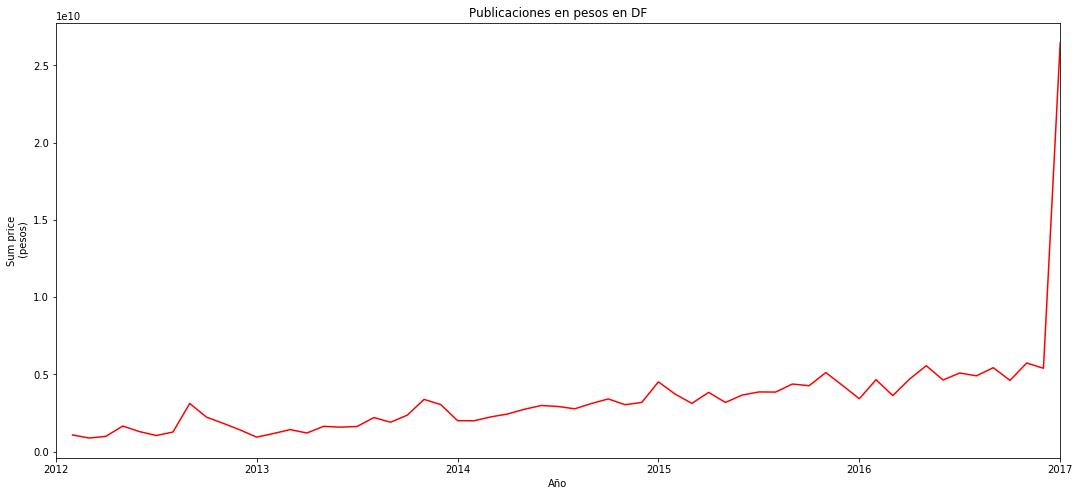

In [166]:
#plt.
df_by_months = df8['fecha'].apply(func = (lambda t : (t.year-2012)*12+t.month))
df8.groupby(df_by_months).precio.sum().plot(c='r',linewidth =1.5, figsize = [18,8])

plt.title('Publicaciones en pesos en DF')
plt.xticks(np.arange(0,61,12),np.arange(2012,2018,1))
plt.xlabel('Año')
plt.ylabel('Sum price\n (pesos)')

plt.show()

In [34]:
df8 = df.copy()

df8 = df8[['precio','fecha', 'provincia']]
df8.dropna(inplace= True)
df8['fecha'] = df8['fecha'].apply(func = (lambda x :(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))))
aux = df8.fecha.apply(lambda x: x.month < 9 if x.year == 2016 else True)
df8 = df8[aux]

In [ ]:
#
# https://stackoverflow.com/questions/4805048/how-to-get-different-colored-lines-for-different-plots-in-a-single-figure
#

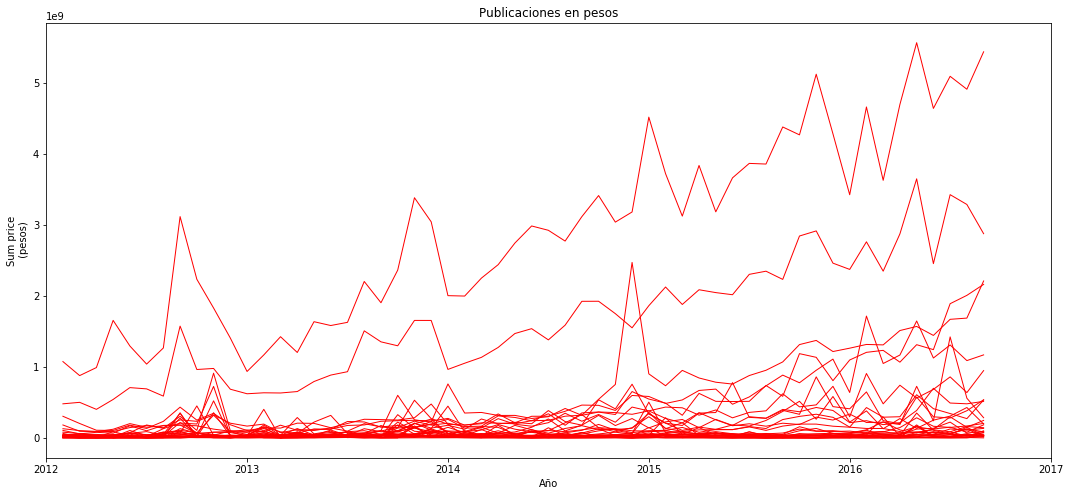

In [42]:
#plt.
df_by_months = df8['fecha'].apply(func = (lambda t : (t.year-2012)*12+t.month))

for prov in df8.provincia.unique():
        df8.loc[df8.provincia == prov].groupby(df_by_months).precio.sum().plot(c='r',linewidth =1, figsize = [18,8])

plt.title('Publicaciones en pesos')
plt.xticks(np.arange(0,61,12),np.arange(2012,2018,1))
plt.xlabel('Año')
plt.ylabel('Sum price\n (pesos)')

plt.show()

In [ ]:
#
# EL PLOT DEBERIA TENER UNA LINEA DE CADA COLOR PARA CADA PROVINCIA Y UNA LEGENDA POR CADA UNA
#

### Punto 9 

In [ ]:
# graficar inflacion en precio de propiedades de MX

In [133]:
df9 = df.copy()

df9 = df9[['precio','fecha']]
df9.dropna(inplace= True)

df9['fecha'] = df9['fecha'].apply(func = (lambda x :(datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))))

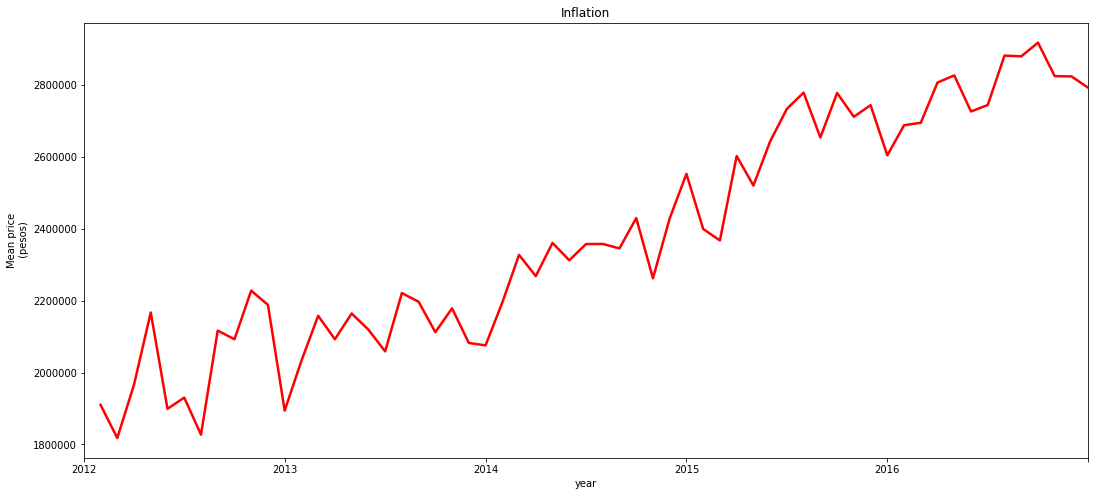

In [134]:
df_by_months = df9['fecha'].apply(func = (lambda t : (t.year-2012)*12+t.month))
df9 = df9.groupby(df_by_months).precio.mean()
df9.plot(c='r',linewidth =2.5, figsize = [18,8])

plt.title('Inflation')
plt.xticks(np.arange(0,61,12),np.arange(2012,2018,1))
plt.xlabel('Año')
plt.ylabel('Mean price\n (pesos)')
plt.show()